<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis-and-Metric" data-toc-modified-id="Exploratory-Data-Analysis-and-Metric-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis and Metric</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Submit" data-toc-modified-id="Submit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Submit</a></span></li><li><span><a href="#Homework" data-toc-modified-id="Homework-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Homework</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tqdm
from collections import Counter
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score

In [2]:
SEED = 42

In [3]:
DATA_PATH = './data/competition_data'

**[Kaggle InClass: Language Detection](https://www.kaggle.com/t/bb11ace54b1a465e91b8c3f46a840ce0)**

# Exploratory Data Analysis and Metric

In [4]:
train_df = pd.read_csv(f'{DATA_PATH}/train.csv')
test_df = pd.read_csv(f'{DATA_PATH}/test.csv')

In [6]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [7]:
train_df.head(15)

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
5,"Na primjer , pjesnik ga opisuje ovako .",hr
6,Semua rerumputan itu sekarang menutupi tanah s...,id
7,Det är en enorm utmaning för oss att göra det .,sv
8,Ono što ćete vidjeti - trebat ćete skočiti ovd...,hr
9,( Alqışlar ) Excel-dən istifadə etmişəm .,az


In [6]:
lang_count = (
    train_df.language.value_counts()
    .to_frame()
    .reset_index()
)

lang_count.head()

,index,language
0,ru,181970
1,en,157655
2,fr,148585
3,vi,113193
4,ar,110032


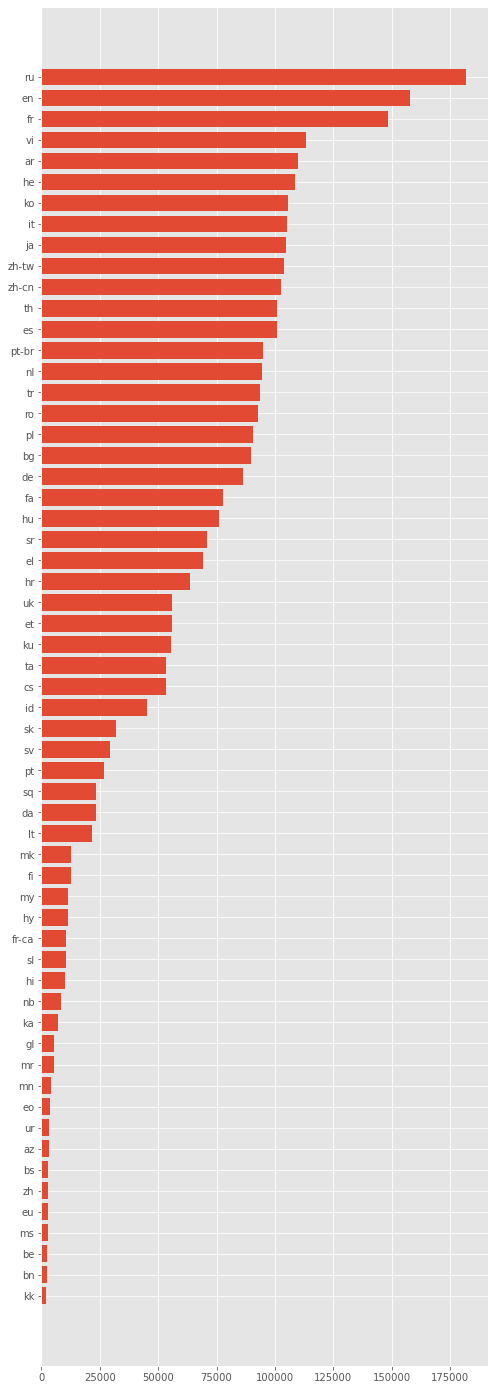

In [7]:
fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])
ax.invert_yaxis();

In [19]:
lang_count[lang_count['index'].apply(lambda x: x in {"en", "kk"})]

,index,language
1,en,157655
58,kk,2046


In [ ]:
TOKEN_PATTERN = "[а-яё]+"

Датасет сильно не сбалансирован по классам, а требуется хорошее качество для всех языков, поэтому метрика в данном соревновании — взвешенная доля правильных ответов:

$$ 
\text{WeightedAccuracy}\left(y, \hat{y}, w\right) = \frac{\displaystyle{\sum_{i=1}^{n}} w_i \cdot \left(y_i == \hat{y}_i\right)}{\displaystyle\sum_{i=1}^{n} w_i } 
$$

Веса выбирались обратно пропорционально количеству примеров соответствующего языка:
$$
w\left(\text{"en"}\right) \sim \frac{1}{157655}
$$
$$ \dots $$
$$
w\left(\text{"kk"}\right) \sim \frac{1}{2046}
$$

Поэтому для валидации можно использовать [sklearn.metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

# Model

In [20]:
x = train_df.values[:, 0]
label_encoder = LabelEncoder().fit(train_df.values[:, 1])
y = label_encoder.transform(train_df.values[:, 1])

In [21]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', SGDClassifier(random_state=SEED, loss='log'))
])

In [106]:
char_tfidf_model = Pipeline([
    (
        'vectorizer',
        TfidfVectorizer(
            lowercase=True, ngram_range=(2, 4), analyzer='char',  min_df=5, max_df=0.8
        )
    ),
    ('clf', SGDClassifier(random_state=SEED, class_weight='balanced'))
])

In [107]:
pipe.fit(x, y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model', SGDClassifier(loss='log', random_state=42))])

In [108]:
char_tfidf_model.fit(x,y)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', max_df=0.8, min_df=5,
                                 ngram_range=(2, 4))),
                ('clf',
                 SGDClassifier(class_weight='balanced', random_state=42))])

In [109]:
predictions = char_tfidf_model.predict(x)

In [111]:
balanced_accuracy_score(y, predictions)

0.8983864162107623

In [132]:
failed = pd.DataFrame({'language': label_encoder.classes_[y[predictions!=y]]})

In [133]:
lang_count_failed = (
    failed.language.value_counts()
    .to_frame()
    .reset_index()
)
lang_count_failed.head()

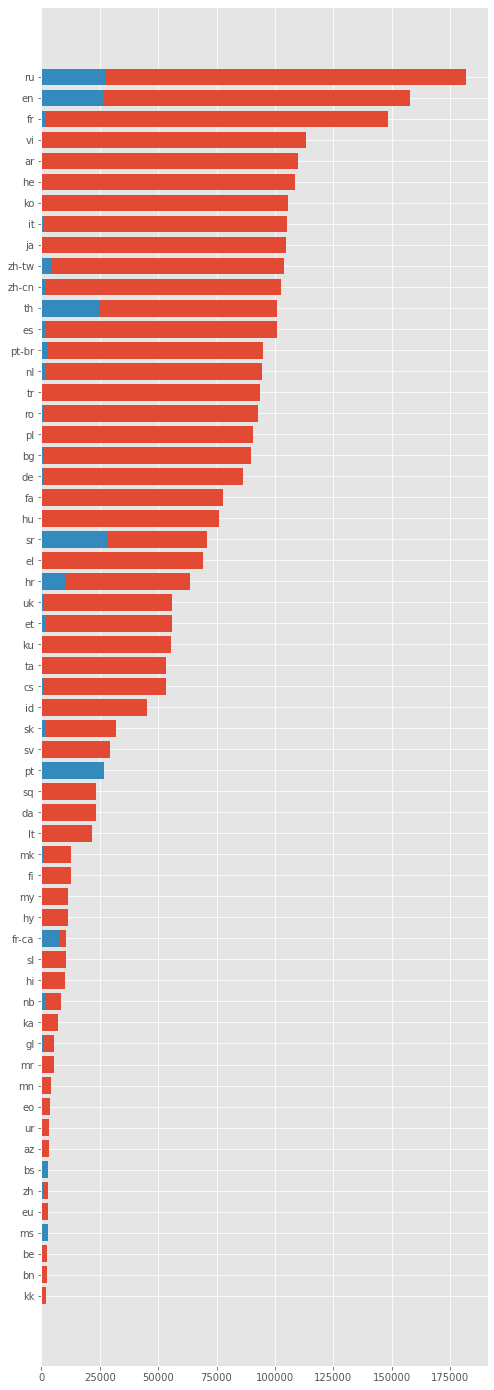

In [139]:
fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])
ax.barh(lang_count_failed['index'], lang_count_failed['language'])
ax.invert_yaxis();

In [167]:
train_df[predictions!=y]

,sentence,language
56,Ali neke zemlje imaju čvršći stav o ovome od o...,sr
83,"Tom Hanks : Salut , Houston , aici Odyssey .",ro
91,що це тому ми чи дуже які щоб дякую якщо було ...,ru
92,Na kraju se ispostavilo da ima puno pojava koj...,sr
96,En gang ? To gange ? 17 gange ?,da
...,...,...
3159570,棒透了 。,zh-tw
3159582,що це тому ми чи дуже які щоб дякую якщо було ...,ru
3159584,A Cheka foi o ídolo dos agentes da Stasi .,pt-br
3159619,що це тому ми чи дуже які щоб дякую якщо було ...,ru


In [168]:
failed_df = train_df[predictions!=y]

In [203]:
failed_df.loc[failed_df.language=='ru']

,sentence,language
91,що це тому ми чи дуже які щоб дякую якщо було ...,ru
305,що це тому ми чи дуже які щоб дякую якщо було ...,ru
348,Мне не хватает Майкла .,ru
857,що це тому ми чи дуже які щоб дякую якщо було ...,ru
980,що це тому ми чи дуже які щоб дякую якщо було ...,ru
...,...,...
3159332,що це тому ми чи дуже які щоб дякую якщо було ...,ru
3159462,Глагол - основа предложения .,ru
3159484,що це тому ми чи дуже які щоб дякую якщо було ...,ru
3159582,що це тому ми чи дуже які щоб дякую якщо було ...,ru


In [8]:
trash = train_df.sentence.value_counts().to_frame().reset_index()
trash.head()

,index,sentence
0,що це тому ми чи дуже які щоб дякую якщо було ...,75000
1,the and of it that you to apos we this is in t...,50000
2,що це ми не як на вони та але ви до про він оп...,50000
3,гэта што калі мы не яны як але ён каб дзякуй б...,50000
4,это что мы не как на вы они но из то он так дл...,50000


In [9]:
trash = trash.loc[trash.sentence>1]

In [5]:
df_clean = train_df.drop_duplicates(subset=['sentence'], keep=False)

In [6]:
x_clean = df_clean.values[:, 0]
label_encoder = LabelEncoder().fit(df_clean.values[:, 1])
y_clean = label_encoder.transform(df_clean.values[:, 1])

In [12]:
model = Pipeline([
    (
        'vectorizer',
        TfidfVectorizer(
            lowercase=True, ngram_range=(2, 10), analyzer='char',  min_df=5, max_df=0.8
        )
    ),
    ('clf', SGDClassifier(random_state=SEED, class_weight='balanced'))
])

In [13]:
model.fit(x_clean, y_clean)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', max_df=0.8, min_df=5,
                                 ngram_range=(2, 4))),
                ('clf',
                 SGDClassifier(class_weight='balanced', random_state=42))])

In [14]:
predictions = model.predict(x_clean)
balanced_accuracy_score(y_clean, predictions)

0.9093139839157018

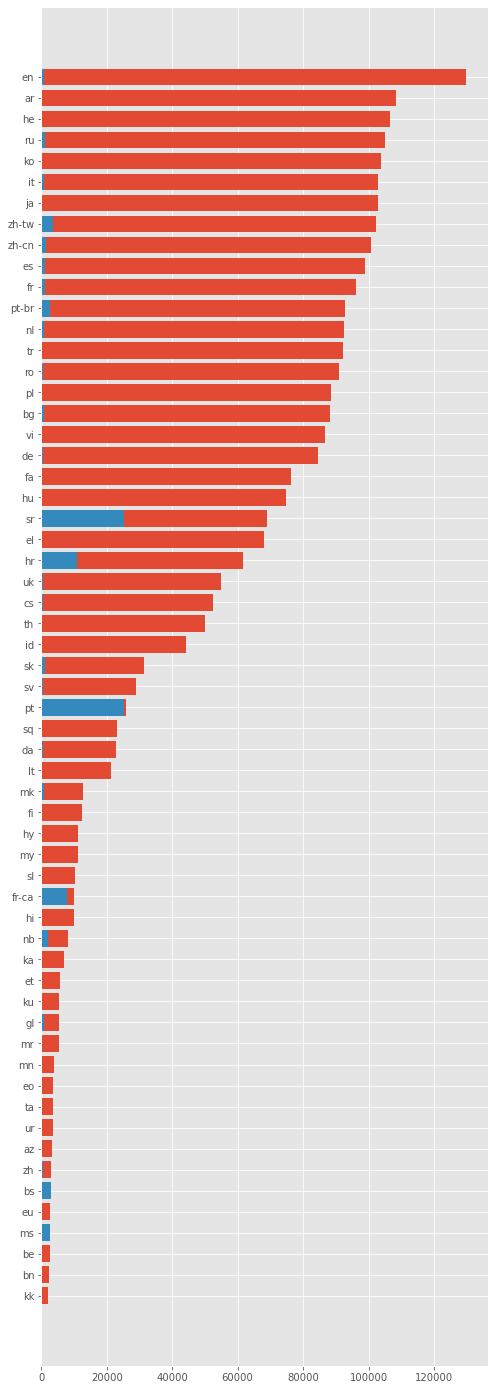

In [15]:
lang_count = (
    df_clean.language.value_counts()
    .to_frame()
    .reset_index()
)

failed = pd.DataFrame({'language': label_encoder.classes_[y_clean[predictions!=y_clean]]})

lang_count_failed = (
    failed.language.value_counts()
    .to_frame()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])
ax.barh(lang_count_failed['index'], lang_count_failed['language'])
ax.invert_yaxis();

# Submit

In [16]:
submit_predictions = model.predict(test_df.sentence.values)

In [17]:
test_df['language'] = label_encoder.classes_[submit_predictions]

test_df.head()

,index,sentence,language
0,0,תודה לכם .,he
1,1,"Precisamos de compaixão para começar , e auto-...",pt-br
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,zh-tw
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,ko
4,4,これをロボットに組み込みました,ja


In [18]:
(
    test_df[['index', 'language']]
    .to_csv(f'{DATA_PATH}/sample_submission.csv', index=False)
)

In [89]:
!head $DATA_PATH/sample_submission.csv

"head" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


# Homework

- выбить хороший score на private leaderboard'е (8 баллов)
- совет: поищите ошибки в train-части датасета

In [1]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch 
import torch.nn.functional as F
import time
import tqdm


seed = 1111
random.seed(seed)
np.random.RandomState(seed)
torch.manual_seed(seed)

DATA_PATH = './data/competition_data'
train_df = pd.read_csv(f'{DATA_PATH}/train.csv')
test_df = pd.read_csv(f'{DATA_PATH}/test.csv')
df_clean = train_df.drop_duplicates(subset=['sentence'], keep=False)
df = df_clean.copy()

x_full = pd.concat([df['sentence'], test_df['sentence']], axis=0)
x_train_full = df['sentence']
y_train_full = df['language']
print('Example:')
print('LANG =', y_train_full[0])
print('TEXT =', x_train_full[0])

Example:
LANG = fr
TEXT = Pensez à la communication , le discours , les gestes , écrire , le langage des signes , ils sont tous faits par l&apos; intermédiaire de contractions musculaires .


In [2]:
class Dictionary(object):
    def __init__(self):
        self.token2idx = {}
        self.idx2token = []

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def __len__(self):
        return len(self.idx2token)

In [3]:
char_vocab = Dictionary()
pad_token = '<pad>' # reserve index 0 for padding
unk_token = '<unk>' # reserve index 1 for unknown token
pad_index = char_vocab.add_token(pad_token)
unk_index = char_vocab.add_token(unk_token)

# join all the training sentences in a single string
# and obtain the list of different characters with set
chars = set(''.join(x_full))
for char in sorted(chars):
    char_vocab.add_token(char)
print("Vocabulary:", len(char_vocab), "UTF characters")

lang_vocab = Dictionary()
# use python set to obtain the list of languages without repetitions
languages = set(y_train_full)
for lang in sorted(languages):
    lang_vocab.add_token(lang)
print("Labels:", len(lang_vocab), "languages")

Vocabulary: 10813 UTF characters
Labels: 59 languages


In [4]:
#From token or label to index
print('k ->', char_vocab.token2idx['k'])
print('fr ->', lang_vocab.token2idx['fr'])
print(y_train_full[0], x_train_full[0][:10])
x_train_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in x_train_full]
y_train_idx = np.array([lang_vocab.token2idx[lang] for lang in y_train_full])
print(y_train_idx[0], x_train_idx[0][:10])

k -> 72
fr -> 17
fr Pensez à l
17 [ 47  66  75  80  66  87   2 172   2  73]


In [5]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_idx, y_train_idx, test_size=0.2, random_state=42, shuffle=True)
train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
print(len(train_data), "training samples")
print(len(val_data), "validation samples")

2184318 training samples
546080 validation samples


In [6]:
def batch_generator(data, batch_size, token_size):
    """Yield elements from data in chunks with a maximum of batch_size sequences and token_size tokens."""
    minibatch, sequences_so_far, tokens_so_far = [], 0, 0
    for ex in data:
        seq_len = len(ex[0])
        if seq_len > token_size:
            ex = (ex[0][:token_size], ex[1])
            seq_len = token_size
        minibatch.append(ex)
        sequences_so_far += 1
        tokens_so_far += seq_len
        if sequences_so_far == batch_size or tokens_so_far == token_size:
            yield minibatch
            minibatch, sequences_so_far, tokens_so_far = [], 0, 0
        elif sequences_so_far > batch_size or tokens_so_far > token_size:
            yield minibatch[:-1]
            minibatch, sequences_so_far, tokens_so_far = minibatch[-1:], 1, len(minibatch[-1][0])
    if minibatch:
        yield minibatch

In [7]:
def pool_generator(data, batch_size, token_size, shuffle=False):
    """Sort within buckets, then batch, then shuffle batches.
    Partitions data into chunks of size 100*token_size, sorts examples within
    each chunk, then batch these examples and shuffle the batches.
    """
    for p in batch_generator(data, batch_size * 100, token_size * 100):
        p_batch = batch_generator(sorted(p, key=lambda t: len(t[0]), reverse=True), batch_size, token_size)
        p_list = list(p_batch)
        if shuffle:
            for b in random.sample(p_list, len(p_list)):
                yield b
        else:
            for b in p_list:
                yield b

In [8]:
class CharRNNClassifier(torch.nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, output_size, model="lstm", num_layers=1, bidirectional=False, pad_idx=0):
        super().__init__()
        self.model = model.lower()
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(input_size, embedding_size, padding_idx=pad_idx)
        if self.model == "gru":
            self.rnn = torch.nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        elif self.model == "lstm":
            self.rnn = torch.nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, input, input_lengths):
        # T x B
        encoded = self.embed(input)
        # T x B x E
        packed = torch.nn.utils.rnn.pack_padded_sequence(encoded, input_lengths)
        # Packed T x B x E
        output, _ = self.rnn(packed)
        # Packed T x B x H
        # Important: you may need to replace '-inf' with the default zero padding for other pooling layers
        padded, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=float('-inf'))
        # T x B x H
        output, _ = padded.max(dim=0)
        # B x H
        output = self.h2o(output)
        # B x O
        return output

In [9]:
if not torch.cuda.is_available():
    print("WARNING: CUDA is not available. Select 'GPU On' on kernel settings")
device = torch.device("cuda")
torch.cuda.manual_seed(seed)

In [10]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [11]:
def train(model, optimizer, data, batch_size, token_size, max_norm=1, log=False):
    model.train()
    total_loss = 0
    ncorrect = 0
    nsentences = 0
    ntokens = 0
    niterations = 0
    for batch in pool_generator(data, batch_size, token_size, shuffle=True):
        # Get input and target sequences from batch
        X = [torch.from_numpy(d[0]) for d in batch]
        X_lengths = [x.numel() for x in X]
        ntokens += sum(X_lengths)
        X_lengths = torch.tensor(X_lengths, dtype=torch.long)
        y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
        # Pad the input sequences to create a matrix
        X = torch.nn.utils.rnn.pad_sequence(X).to(device)
        model.zero_grad()
        output = model(X, X_lengths)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)    
        optimizer.step()
        # Training statistics
        total_loss += loss.item()
        ncorrect += (torch.max(output, 1)[1] == y).sum().item()
        nsentences += y.numel()
        niterations += 1
    
    total_loss = total_loss / nsentences
    accuracy = 100 * ncorrect / nsentences
    if log:
        print(f'Train: wpb={ntokens//niterations}, bsz={nsentences//niterations}, num_updates={niterations}')
    return accuracy

In [12]:
def validate(model, data, batch_size, token_size):
    model.eval()
    # calculate accuracy on validation set
    ncorrect = 0
    nsentences = 0
    with torch.no_grad():
        for batch in pool_generator(data, batch_size, token_size):
            # Get input and target sequences from batch
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)
            y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
            # Pad the input sequences to create a matrix
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            ncorrect += (torch.max(answer, 1)[1] == y).sum().item()
            nsentences += y.numel()
        dev_acc = 100 * ncorrect / nsentences
    return dev_acc

In [13]:
hidden_size = 300
embedding_size = 64
bidirectional = False
ntokens = len(char_vocab)
nlabels = len(lang_vocab)

In [14]:
def get_model():
    model = CharRNNClassifier(ntokens, embedding_size, hidden_size, nlabels, bidirectional=bidirectional, pad_idx=pad_index).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    return model, optimizer

In [16]:
# Пробуем обучать на всей дате без валидации
train_data = [(x, y) for x, y in zip(x_train_idx, y_train_idx)]

batch_size, token_size = 300, 200000
epochs = 20
train_accuracy = []
valid_accuracy = []
model, optimizer = get_model()
print(f'Training cross-validation model for {epochs} epochs')
t0 = time.time()
for epoch in range(1, epochs + 1):
    acc = train(model, optimizer, train_data, batch_size, token_size, log=epoch==1)
    train_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | train accuracy={acc:.1f}% ({time.time() - t0:.0f}s)')
#     acc = validate(model, val_data, batch_size, token_size)
#     valid_accuracy.append(acc)
#     print(f'| epoch {epoch:03d} | valid accuracy={acc:.1f}%')

Training cross-validation model for 20 epochs
Train: wpb=27341, bsz=299, num_updates=9102
| epoch 001 | train accuracy=94.5% (270s)
| epoch 002 | train accuracy=97.4% (539s)
| epoch 003 | train accuracy=97.7% (809s)
| epoch 004 | train accuracy=97.9% (1079s)
| epoch 005 | train accuracy=98.0% (1349s)
| epoch 006 | train accuracy=98.2% (1618s)
| epoch 007 | train accuracy=98.2% (1885s)
| epoch 008 | train accuracy=98.3% (2145s)
| epoch 009 | train accuracy=98.4% (2404s)
| epoch 010 | train accuracy=98.4% (2664s)
| epoch 011 | train accuracy=98.4% (2923s)
| epoch 012 | train accuracy=98.5% (3182s)
| epoch 013 | train accuracy=98.5% (3441s)
| epoch 014 | train accuracy=98.5% (3701s)
| epoch 015 | train accuracy=98.6% (3960s)
| epoch 016 | train accuracy=98.6% (4219s)
| epoch 017 | train accuracy=98.6% (4479s)
| epoch 018 | train accuracy=98.6% (4738s)
| epoch 019 | train accuracy=98.6% (4997s)
| epoch 020 | train accuracy=98.6% (5263s)


In [17]:
x_test_full = test_df['sentence']
x_test_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in x_test_full]
test_data = [(x, y) for x, y in zip(x_test_idx, list(test_df['index']))]

In [18]:
def predict(model, data, batch_size, token_size):
    answers=pd.DataFrame({'index': [], 'language': []})
    model.eval()
    
    with torch.no_grad():
        for batch in tqdm.tqdm(pool_generator(data, batch_size, token_size), total=len(list(pool_generator(test_data, batch_size, token_size)))):
            tmp = pd.DataFrame({'index': [], 'language': []})
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)
            tmp['index'] = [d[1] for d in batch]
            # Pad the input sequences to create a matrix
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            _, predicted = torch.max(answer, 1)
            tmp['language'] = pd.DataFrame(predicted.cpu().numpy())
            answers = pd.concat([answers, tmp], axis=0)
            
    answers = answers.sort_values(by=['index']).astype(int).reset_index(drop=True)
    answers['language'] = [lang_vocab.idx2token[idx] for idx in answers['language']]
    
    return answers

In [19]:
answers = predict(model, test_data, 256, token_size)

100%|████████████████████████████████████████████████████████████████████████████| 10878/10878 [02:29<00:00, 72.66it/s]


In [20]:
(
    answers
    .to_csv(f'{DATA_PATH}/submission.csv', index=False)
)

In [64]:
# train_full = [(x, y) for x, y in zip(x_train_idx, df.index)]

In [65]:
# train_predict = predict(model, train_full, 256, token_size)

 98%|██████████████████████████████████████████████████████████████████████████▌ | 10666/10878 [02:30<00:02, 71.08it/s]


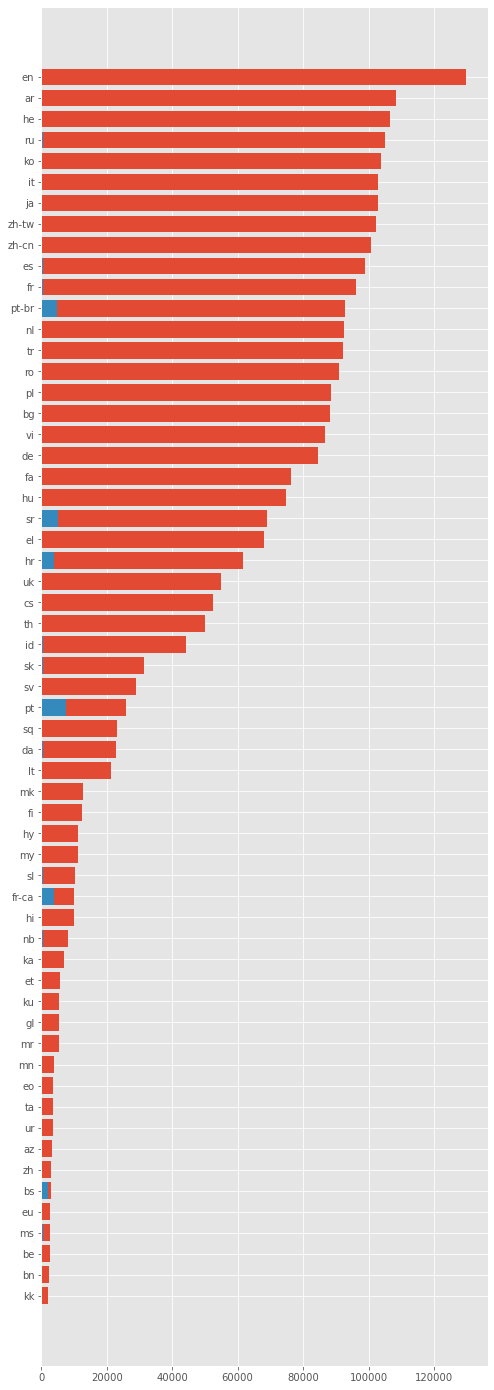

In [66]:
# lang_count = (
#     df.language.value_counts()
#     .to_frame()
#     .reset_index()
# )

# failed = pd.DataFrame({'language': df.language[train_predict.language.values!=df.language.values]})

# lang_count_failed = (
#     failed.language.value_counts()
#     .to_frame()
#     .reset_index()
# )

# fig, ax = plt.subplots(figsize=(8,25))

# ax.barh(lang_count['index'], lang_count['language'])
# ax.barh(lang_count_failed['index'], lang_count_failed['language'])
# ax.invert_yaxis();